# accessing data

In [1]:
# !ls
# !pip install pandas
# !pip install scikit-learn
# !pip install matplotlib
# !pip install xarray
# !pip install gcsfs
# !pip install tqdm
# !pip install numpy

In [1]:
import pandas as pd

df = pd.read_csv("/Users/alexanderfeil/Desktop/studies/2 Master/2 Fall Term/machine learning/project/FPA-FOD_39attributes.csv", low_memory = False)
# df = df.drop('Unnamed: 0', axis = 'columns') #drops the items where columns are unnamed

In [2]:
# Importing their table
df = pd.read_csv("/Users/alexanderfeil/Desktop/studies/2 Master/2 Fall Term/machine learning/project/the paper/FPA_FOD_west_cleaned.csv", low_memory = False)
df = df[~df['NWCG_GENERAL_CAUSE'].str.contains('Missing data/not specified/undetermined', na=False)]
# df["NWCG_GENERAL_CAUSE"].value_counts()

In [ ]:
# cols_to_exclude = ["FRG_1km_percent", "EVC_1km_percent", "road_county_dis", "No_FireStation_1.0km", "Evacuation", "GACC_PL"]
# cols_to_exclude = ["FRG_1km_percent", "EVC_1km_percent", "No_FireStation_1.0km", "Evacuation", "GACC_PL", "road_county_dis"]

# rows_with_na = df[~df.drop(columns=cols_to_exclude).isna().any(axis=1)]


KeyError: "['FRG_1km_percent', 'EVC_1km_percent', 'No_FireStation_1.0km', 'road_county_dis'] not found in axis"

# Processing data

In [3]:
unknown_mask = df['NWCG_GENERAL_CAUSE'] == "Missing data/not specified/undetermined"

df_known = df[~unknown_mask].copy()
df_unknown = df[unknown_mask].copy()

In [ ]:
# #turn NDVI into separate columns

# ndvi_split = df_known['NDVI_mean'].str.split(' ', expand=True)
# ndvi_split.columns = [f"NDVI{k+1}" for k in range(ndvi_split.shape[1])]
# df2 = pd.concat([df_known, ndvi_split], axis=1)
# ndvi_cols = [f"NDVI{k+1}" for k in range(12)]
# for col in ndvi_cols:
#     df2[col] = df2[col].str.strip("'\"")  # Remove single or double quotes
#     df2[col] = pd.to_numeric(df2[col], errors='coerce')  # Convert to float, coercing errors
# df2.head()

In [4]:
X = df_known.drop(columns=['NWCG_GENERAL_CAUSE'])
y = df_known['NWCG_GENERAL_CAUSE']

In [5]:
X = X.fillna(X.median(numeric_only=True)) #replace NANs

for col in X.columns: #convert numeric values to floats, if possible
    if X[col].dtype == 'object':
        # try converting to float — if it works, keep it numeric
        try:
            X[col] = X[col].astype(float)
        except ValueError:
            pass

In [6]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_encoded = le.fit_transform(y) #encode the textual output


# Splitting the data into train and test sets

In [ ]:
# from sklearn.model_selection import train_test_split

# # Combine X and y into one DataFrame temporarily
# df3 = X.copy()

# df3['cause'] = y_encoded

# # Split back into X and y
# X = df3.drop(columns=['cause'])
# y = df3['cause']

# # Now do your train-test split as usual
# X_train_df, X_test_df, y_train_df, y_test_df = train_test_split(
#     X, y, test_size=0.2, random_state=42, stratify=y
# )

# if isinstance(y_train_df, pd.Series):
#     y_train_df = y_train_df.to_frame(name='cause')

# if isinstance(y_test_df, pd.Series):
#     y_test_df = y_test_df.to_frame(name='cause')


(1363952, 43) (340988, 43)
Index(['pr', 'tmmn', 'tmmx', 'rmin', 'rmax', 'sph', 'srad', 'etr', 'vpd', 'bi',
       'erc', 'fm100', 'fm1000', 'EVC', 'EVT', 'EVH', 'Elevation', 'Slope',
       'Aspect', 'TRI', 'TPI', 'Aridity_index', 'Population', 'GDP',
       'LATITUDE', 'LONGITUDE', 'STATE', 'COUNTY', 'FIRE_YEAR',
       'DISCOVERY_DOY', 'DISCOVERY_TIME', 'NDVI1', 'NDVI2', 'NDVI3', 'NDVI4',
       'NDVI5', 'NDVI6', 'NDVI7', 'NDVI8', 'NDVI9', 'NDVI10', 'NDVI11',
       'NDVI12'],
      dtype='object')
cause
1        428414
6        261814
0        256539
2        152150
10        79570
5         53022
11        51016
9         29828
8         26122
4         14878
7          8413
3          2186
Name: count, dtype: int64


### Evenly Balanced Size Reduction

In [ ]:
# from sklearn.model_selection import train_test_split

# # Combine X and y into one DataFrame temporarily
# df2 = X.copy()

# df2['cause'] = y_encoded

# df_balanced = (
#     df2.groupby('cause', group_keys=False)
#       .apply(lambda x: x.sample(n=min(len(x), 10000), random_state=42))
#       .reset_index(drop=True)
# )

# # Split back into X and y
# X_balanced = df_balanced.drop(columns=['cause'])
# y_balanced = df_balanced['cause']

# # Now do your train-test split as usual
# df_known, X_test_df, y_train_df, y_test_df = train_test_split(
#     X_balanced, y_balanced, test_size=0.2, random_state=42, stratify=y_balanced
# )

# print(X_train_df.shape, X_test_df.shape)
# print(y_train_df.value_counts())

/var/folders/9p/1xc4qsqs6wv7ng86fqksqfrr0000gn/T/ipykernel_87485/731912646.py:9: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df2.groupby('cause', group_keys=False)


(90186, 32) (22547, 32)
cause
11    8000
6     8000
10    8000
8     8000
0     8000
7     8000
2     8000
4     8000
1     8000
5     8000
9     8000
3     2186
Name: count, dtype: int64


### Size Reduction by initial distribution

In [7]:
from sklearn.model_selection import train_test_split

# Combine X and y
df3 = X.copy()
df3['cause'] = y_encoded

# Calculate per-class limits (as you did before)
limits = (df3['cause'].value_counts() / 10).round(0)

# Sample per-class, capped at the class-specific limit
df3 = (
    df3.groupby('cause', group_keys=False)
       .apply(lambda x: x.sample(n=int(min(len(x), limits.loc[x.name])), random_state=42))
       .reset_index(drop=True)
)

# Split back into X and y
X = df3.drop(columns=['cause'])
y = df3['cause']

# Usual train-test split, stratified
X_train_df, X_test_df, y_train_df, y_test_df = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_train_df.head()

/var/folders/9p/1xc4qsqs6wv7ng86fqksqfrr0000gn/T/ipykernel_68449/3608912719.py:12: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df3.groupby('cause', group_keys=False)


,DISCOVERY_DOY,FIRE_YEAR,STATE,FIPS_CODE,Annual_etr,Annual_precipitation,Annual_tempreture,pr,tmmn,vs,...,GHM,NDVI-1day,NPL,Popo_1km,RPL_THEMES,RPL_THEME1,RPL_THEME2,RPL_THEME3,RPL_THEME4,Distance2road
20569,183,2000,ID,0.0,1355,450,279.0,0.9,284.200012,2.5,...,0.04,0.35,2.0,0.0000,0.540,0.714,0.723,0.076,0.480,30.8
5651,177,2005,OR,41029.0,1608,661,285.0,0.0,283.500000,2.9,...,0.32,0.21,2.0,0.1292,0.390,0.548,0.534,0.092,0.291,43.2
23837,231,2004,WA,53047.0,981,1015,276.0,0.0,283.700012,2.1,...,0.00,0.44,3.0,0.0000,0.400,0.447,0.170,0.006,0.778,11.1
5492,174,2006,OR,41029.0,1533,1029,281.0,0.0,280.899994,3.1,...,0.06,0.65,3.0,0.0000,0.334,0.476,0.299,0.019,0.464,26.8
17422,243,2009,ID,16049.0,1274,1278,280.0,0.6,284.200012,2.1,...,0.05,0.53,2.0,0.0000,0.329,0.741,0.304,0.032,0.203,23.3


### Adding Cause Names

In [8]:
cause_names = [
    "Debris and open burning",
    "Misuse of fire by a minor",
    "Equipment and vehicle use",
    "Fireworks",
    "Arson/incendiarism",
    "Power generation/transmission/distribution",
    "Railroad operations and maintenance",
    "Recreation and ceremony",
    "Natural",
    "Smoking",
    "Other causes",
    "Firearms and explosives use"
]

# Convert y_train value counts into a DataFrame for easier mapping
counts = y_train_df.value_counts().reset_index()
counts.columns = ['cause_id', 'count']


# Map encoded ID to name
counts['cause_name'] = counts['cause_id'].map(lambda i: cause_names[i])



print(counts[['cause_id', 'cause_name', 'count']].to_string(index=False))

 cause_id                                 cause_name  count
        6        Railroad operations and maintenance  13468
        2                  Equipment and vehicle use   3919
        1                  Misuse of fire by a minor   3241
       10                               Other causes   3093
        0                    Debris and open burning   2247
       11                Firearms and explosives use   1084
        5 Power generation/transmission/distribution    921
        8                                    Natural    518
        4                         Arson/incendiarism    510
        9                                    Smoking    246
        7                    Recreation and ceremony    166
        3                                  Fireworks    127


# Loading Data

In [12]:
## Turning the filed into CSV

# X_train_df.to_csv("X_train_initial_distr.csv", index=False)
# X_test_df.to_csv("X_test_initial_distr.csv", index=False)
# y_train_df.to_csv("y_train_initial_distar.csv", index=False)
# y_test_df.to_csv("y_test_initial_distr.csv", index=False)
# import files

# import torch

# X_train_df = pd.read_csv("datasets/X_train_df.csv")
# X_train_df = pd.read_csv("/Users/alexanderfeil/Desktop/studies/2 Master/2 Fall Term/machine learning/project/datasets/X_train_all.csv")
# y_train_df = pd.read_csv("/Users/alexanderfeil/Desktop/studies/2 Master/2 Fall Term/machine learning/project/datasets/y_train_all.csv")
# X_test_df = pd.read_csv("/Users/alexanderfeil/Desktop/studies/2 Master/2 Fall Term/machine learning/project/datasets/X_test_all.csv")
# y_test_df = pd.read_csv("/Users/alexanderfeil/Desktop/studies/2 Master/2 Fall Term/machine learning/project/datasets/y_test_all.csv")
# y_train_df = pd.read_csv("datasets/y_train_df.csv")
# X_test_df = pd.read_csv("datasets/X_test_df.csv")
# y_test_df = pd.read_csv("datasets/y_test_df.csv")

# X_train_df.head()

In [ ]:
# paper_vars = ['pr', 'tmmn', 'etr', 'vpd', 'bi', 'erc', 'fm100', 'fm1000', 'NDVI_mean', 'EVC', 'Elevation', 'Slope', 'Aspect', 'TPI', 'Population', 'GDP', 'COUNTY', 'FIRE_YEAR', 'DISCOVERY_DOY']
# my_vars = ['pr', 'tmmn', 'etr', 'vpd', 'bi', 'erc', 'fm100', 'fm1000', 'EVC', 'Elevation', 'Slope', 'Aspect', 'TPI', 'Population', 'GDP', 'DISCOVERY_DOY']

# X_train_df = X_train_df[my_vars]
# X_test_df = X_test_df[my_vars]


1572    10
499      1
1171     6
1595    10
633      1
        ..
774      1
1646    11
1405     6
379      1
1416     6
Name: cause, Length: 1364, dtype: int64

In [9]:
# Standardization
numeric_cols = X_train_df.select_dtypes(include=['number']).columns

# Compute mean and std only on numeric columns
mean = X_train_df[numeric_cols].mean()
std = X_train_df[numeric_cols].std()

# Standardize numeric columns in place
X_train_df[numeric_cols] = (X_train_df[numeric_cols] - mean) / std
X_test_df[numeric_cols] = (X_test_df[numeric_cols] - mean) / std


y_train_df = pd.get_dummies(y_train_df).astype(float)
y_train_df.head()
y_test_df = pd.get_dummies(y_test_df).astype(float)

In [10]:
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder


categorical_features = ['STATE', 'COUNTY']

# preprocessor = ColumnTransformer(
#     transformers=[
#         ('num', SimpleImputer(strategy='median'), numeric_features),
#         ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
#     ])

# # Fit-transform training data and transform test data
# X_train_processed = preprocessor.fit_transform(X_train_df)
# X_test_processed = preprocessor.transform(X_test_df)

# # Convert sparse matrices to dense arrays
X_train = X_train_df[numeric_cols].to_numpy()
X_test = X_test_df[numeric_cols].to_numpy()
y_train = y_train_df.to_numpy()


In [11]:
import torch 

# Convert to PyTorch datasets
train_dataset = torch.utils.data.TensorDataset(torch.FloatTensor(X_train), torch.FloatTensor(y_train))
test_dataset = torch.utils.data.TensorDataset(torch.FloatTensor(X_test))


# Split into train and validation sets
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/runpy.py", line 197, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "/Users/alexanderfeil/Desktop/studies/2 Master/2 Fall Term/machine learning/project/.venv/lib/python3.9/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/Users/alexanderfeil/Des

# Neural Network

In [12]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr

import torch
import torch.nn as nn
from utils import * 

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

plt.rcParams['savefig.dpi'] = 400
plt.rcParams['font.size'] = 13
plt.rcParams["legend.frameon"] = False
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cwd = os.getcwd()

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer


In [15]:
# set hyperparameters
n_neuron       = 32
activation     = 'ReLU' #'ReLU' #'Linear', 'Tanh'
num_epochs     = 50
learning_rate  = 0.0001
minibatch_size = 64
N_layers       = 2 # number of hidden layers
dropout_p = 0.20 #sets probability for dropouts
weight_decay = 1e-5

In [16]:
# Create data loaders for batched training
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=minibatch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=minibatch_size, shuffle=False)

In [345]:

layers = []
layers.append(nn.Linear(X_train.shape[1], n_neuron))
layers.append(getattr(nn, activation)())
layers.append(nn.Dropout(dropout_p))   # <- dropout after first activation

for n in range(N_layers-1):
   layers.append(nn.Linear(n_neuron, n_neuron))
   layers.append(getattr(nn, activation)())
   layers.append(nn.Dropout(dropout_p))

layers.append(nn.Linear(n_neuron, y_train.shape[1]))

model = nn.Sequential(*layers)
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=learning_rate,
    weight_decay=weight_decay  # L2 regularization
    )
criterion = nn.MSELoss()
model.to(device)

Sequential(
  (0): Linear(in_features=38, out_features=32, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.2, inplace=False)
  (3): Linear(in_features=32, out_features=32, bias=True)
  (4): ReLU()
  (5): Dropout(p=0.2, inplace=False)
  (6): Linear(in_features=32, out_features=12, bias=True)
)

In [346]:
best_val_loss = float('inf')
patience_counter = 0
patience = 20

train_losses = []
val_losses = []

for epoch in range(num_epochs):
   # training
   model.train()
   train_loss = 0.0
   for batch_X, batch_y in train_loader:
       batch_X = batch_X.to(device)
       batch_y = batch_y.to(device)
       # forward pass
       optimizer.zero_grad()
       outputs = model(batch_X)
       loss = criterion(outputs, batch_y)
       # backward pass
       loss.backward()
       optimizer.step()
       train_loss += loss.item()

    # validation
   model.eval()
   val_loss = 0.0
   with torch.no_grad():
       for batch_X, batch_y in val_loader:
           batch_X = batch_X.to(device)
           batch_y = batch_y.to(device)
           
           outputs = model(batch_X)
           loss = criterion(outputs, batch_y)
           val_loss += loss.item()
   
   train_loss /= len(train_loader)
   val_loss /= len(val_loader)

   train_losses.append(train_loss)
   val_losses.append(val_loss)
   
   print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')
   
   if val_loss < best_val_loss:
       best_val_loss = val_loss
       patience_counter = 0
   else:
       patience_counter += 1
       if patience_counter >= patience:
           print(f'Early stopping at epoch {epoch+1}')
           break

Epoch 1/50, Train Loss: 0.0805, Val Loss: 0.0601
Epoch 2/50, Train Loss: 0.0631, Val Loss: 0.0524
Epoch 3/50, Train Loss: 0.0580, Val Loss: 0.0494
Epoch 4/50, Train Loss: 0.0545, Val Loss: 0.0480
Epoch 5/50, Train Loss: 0.0525, Val Loss: 0.0471
Epoch 6/50, Train Loss: 0.0514, Val Loss: 0.0466
Epoch 7/50, Train Loss: 0.0506, Val Loss: 0.0461
Epoch 8/50, Train Loss: 0.0496, Val Loss: 0.0457
Epoch 9/50, Train Loss: 0.0492, Val Loss: 0.0454
Epoch 10/50, Train Loss: 0.0485, Val Loss: 0.0452
Epoch 11/50, Train Loss: 0.0479, Val Loss: 0.0448
Epoch 12/50, Train Loss: 0.0475, Val Loss: 0.0446
Epoch 13/50, Train Loss: 0.0473, Val Loss: 0.0444
Epoch 14/50, Train Loss: 0.0471, Val Loss: 0.0442
Epoch 15/50, Train Loss: 0.0467, Val Loss: 0.0440
Epoch 16/50, Train Loss: 0.0466, Val Loss: 0.0439
Epoch 17/50, Train Loss: 0.0463, Val Loss: 0.0437
Epoch 18/50, Train Loss: 0.0460, Val Loss: 0.0436
Epoch 19/50, Train Loss: 0.0458, Val Loss: 0.0434
Epoch 20/50, Train Loss: 0.0457, Val Loss: 0.0432
Epoch 21/

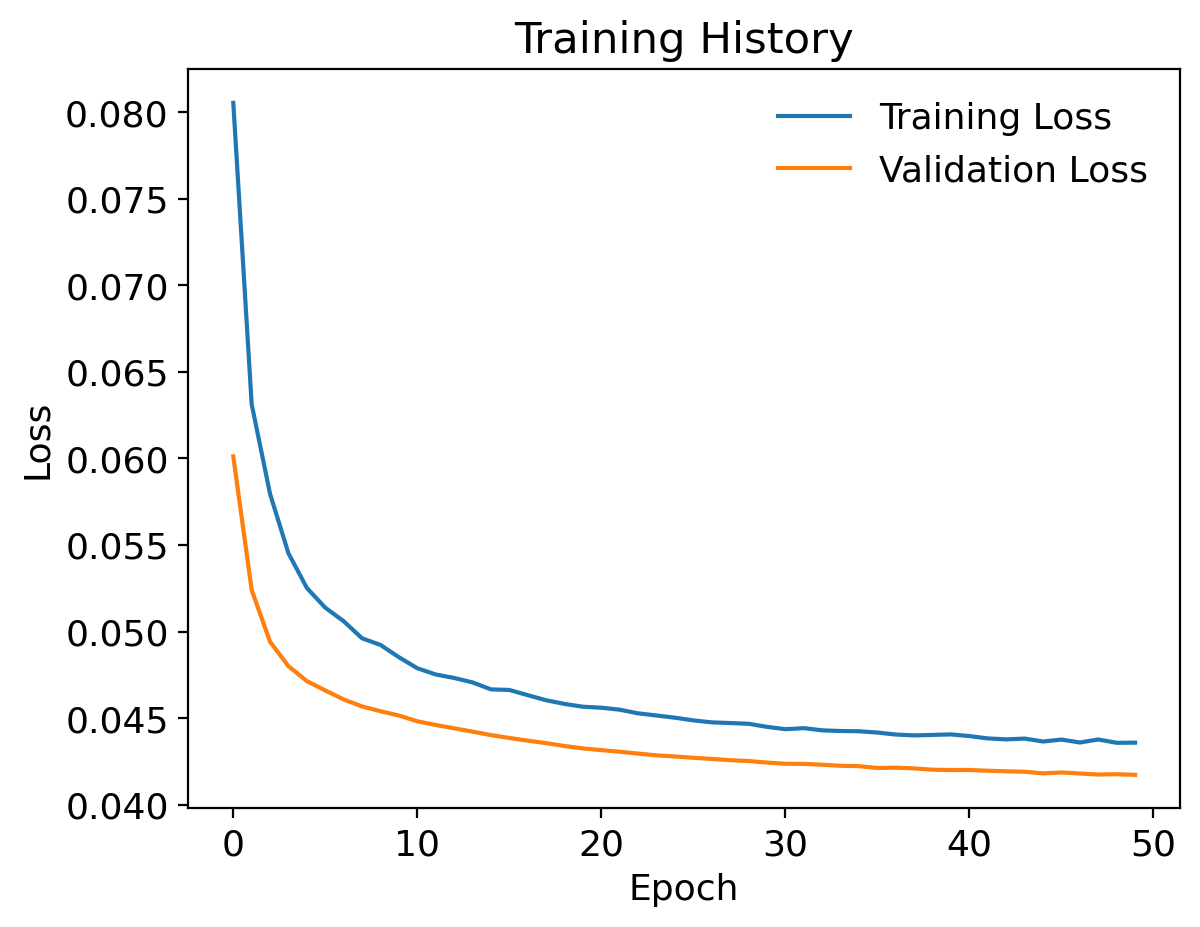

In [347]:
plot_history(train_losses, val_losses)

In [348]:
model_path = os.path.join(cwd,'saved_model')
make_dir(model_path)

In [349]:
# Save the entire model to a pth file.
torch.save(model, os.path.join(model_path, 'NN_model.pth'))

In [350]:
# reload the saved model
model = torch.load(os.path.join(model_path, 'NN_model.pth'), weights_only=False)
model.to(device).eval()

Sequential(
  (0): Linear(in_features=38, out_features=32, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.2, inplace=False)
  (3): Linear(in_features=32, out_features=32, bias=True)
  (4): ReLU()
  (5): Dropout(p=0.2, inplace=False)
  (6): Linear(in_features=32, out_features=12, bias=True)
)

In [351]:
import numpy as np
import pandas as pd
import torch.nn.functional as F

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=minibatch_size, shuffle=False)

model.eval()
predictions = []
with torch.no_grad():
   for batch_X, in test_loader:
       batch_X = batch_X.to(device)
       outputs = model(batch_X)
       probs = F.softmax(outputs, dim=1)  # apply softmax to get probabilities

       # Convert tensor outputs to CPU and then to list (avoid .numpy())
       predictions.append(outputs.cpu().tolist())

# Concatenate list-of-lists into a single list
import itertools
y_test_pre_list = list(itertools.chain.from_iterable(predictions))

# Convert to numpy array after concatenation
y_test_pre = np.array(y_test_pre_list)

cause_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11']
y_pred_df = pd.DataFrame(y_test_pre, columns=cause_names)


In [352]:
# After prediction and concatenation
y_test_pre = np.concatenate(predictions, axis=0)  # shape (num_samples, 12)

cause_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11']
y_pred_df = pd.DataFrame(y_test_pre, columns=cause_names)

# GRIDSEARCH

In [19]:
def train_evaluate_model(hyperparams, patience = 20):
    n_neuron = hyperparams['n_neuron']
    activation = hyperparams['activation']
    learning_rate = hyperparams['learning_rate']
    dropout_p = hyperparams['dropout_p']
    num_epochs = hyperparams['num_epochs']
    
    # Build model layers dynamically as in your code
    layers = []
    layers.append(nn.Linear(X_train.shape[1], n_neuron))
    layers.append(getattr(nn, activation)())
    layers.append(nn.Dropout(dropout_p))
    for n in range(N_layers - 1):
        layers.append(nn.Linear(n_neuron, n_neuron))
        layers.append(getattr(nn, activation)())
        layers.append(nn.Dropout(dropout_p))
    layers.append(nn.Linear(n_neuron, y_train.shape[1]))
    model = nn.Sequential(*layers).to(device)
    
    optimizer = torch.optim.Adam(
        model.parameters(),
        lr=learning_rate,
        weight_decay=weight_decay
    )
    criterion = nn.MSELoss()
    
    # Create dataloaders here or pass them in
    
    best_val_loss = float('inf')
    patience_counter = 0
    
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for batch_X, batch_y in val_loader:
                batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                outputs = model(batch_X)
                loss = criterion(outputs, batch_y)
                val_loss += loss.item()
        
        train_loss /= len(train_loader)
        val_loss /= len(val_loader)
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                break
    
    return best_val_loss


In [20]:
param_grid = {
    'n_neuron': [16, 32],
    'activation': ['ReLU', 'Tanh'],
    'learning_rate': [0.0001, 0.001],
    'dropout_p': [0.1, 0.2],
    'num_epochs': [50]
}

best_hyperparams = None
lowest_val_loss = float('inf')

for n_neuron in param_grid['n_neuron']:
    for activation in param_grid['activation']:
        for lr in param_grid['learning_rate']:
            for dropout in param_grid['dropout_p']:
                hyperparams = {
                    'n_neuron': n_neuron,
                    'activation': activation,
                    'learning_rate': lr,
                    'dropout_p': dropout,
                    'num_epochs': 50,
                }
                val_loss = train_evaluate_model(hyperparams)
                if val_loss < lowest_val_loss:
                    lowest_val_loss = val_loss
                    best_hyperparams = hyperparams

print(f'Best Hyperparams: {best_hyperparams} with Validation Loss: {lowest_val_loss}')


Best Hyperparams: {'n_neuron': 32, 'activation': 'ReLU', 'learning_rate': 0.001, 'dropout_p': 0.1, 'num_epochs': 50} with Validation Loss: 0.04029479422556457


# Calculate RMSE

In [353]:
import numpy as np

# Flatten the DataFrames to 1D arrays (optional but commonly done)
true_values = y_test_df.values.flatten()
pred_values = y_pred_df.values.flatten()

# Calculate RMSE
rmse = np.sqrt(np.mean((true_values - pred_values) ** 2))
print(f'RMSE: {rmse}')


RMSE: 0.20659032608414366


# Make Confusion Matrix

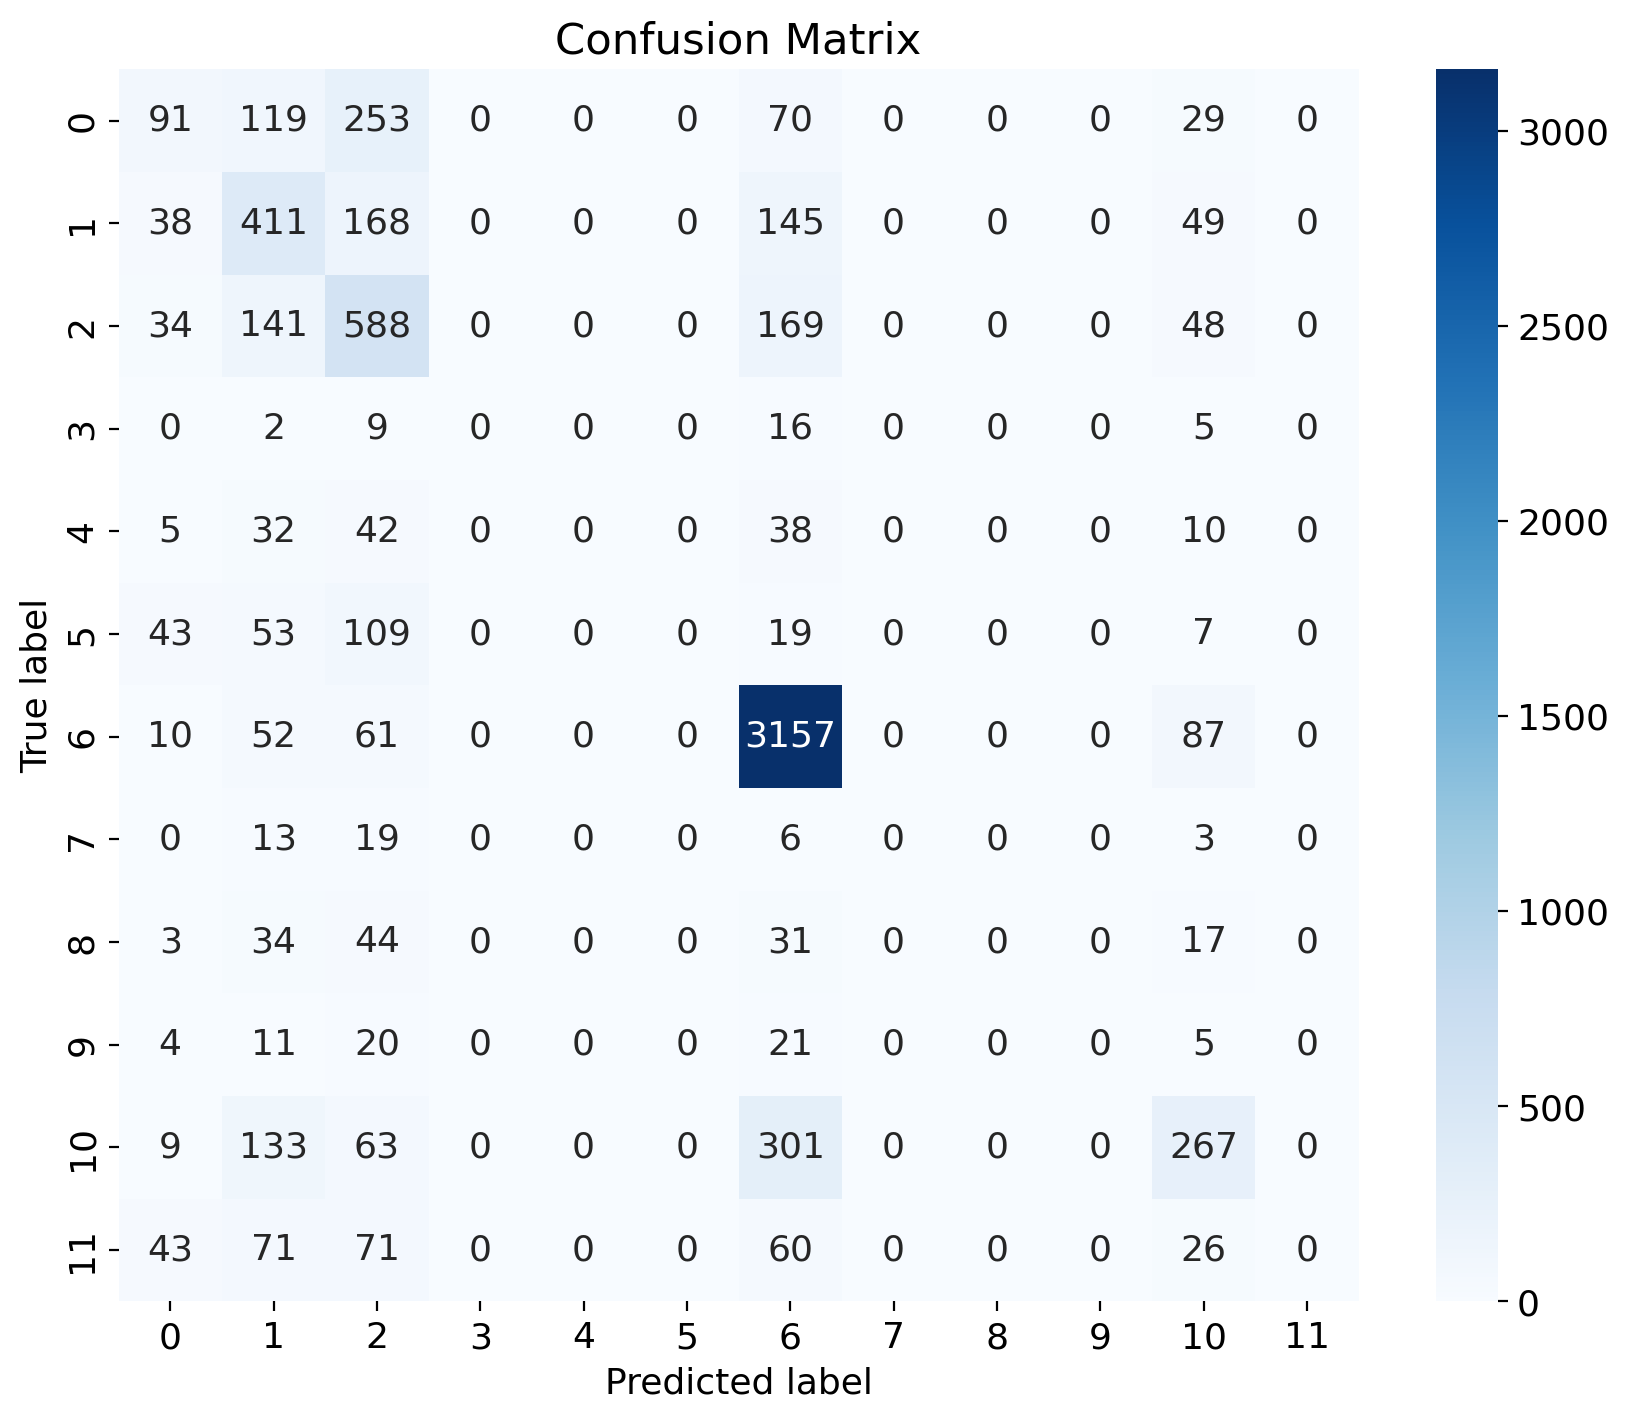

In [354]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# y_test_df and y_pred_df are your dataframes of shape (samples, 12)
# Each row: probabilistic assignment to each cause

# Get true and predicted cause labels by argmax across columns
y_true = np.argmax(y_test_df.values, axis=1)
y_pred = np.argmax(y_pred_df.values, axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=np.arange(12))

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()


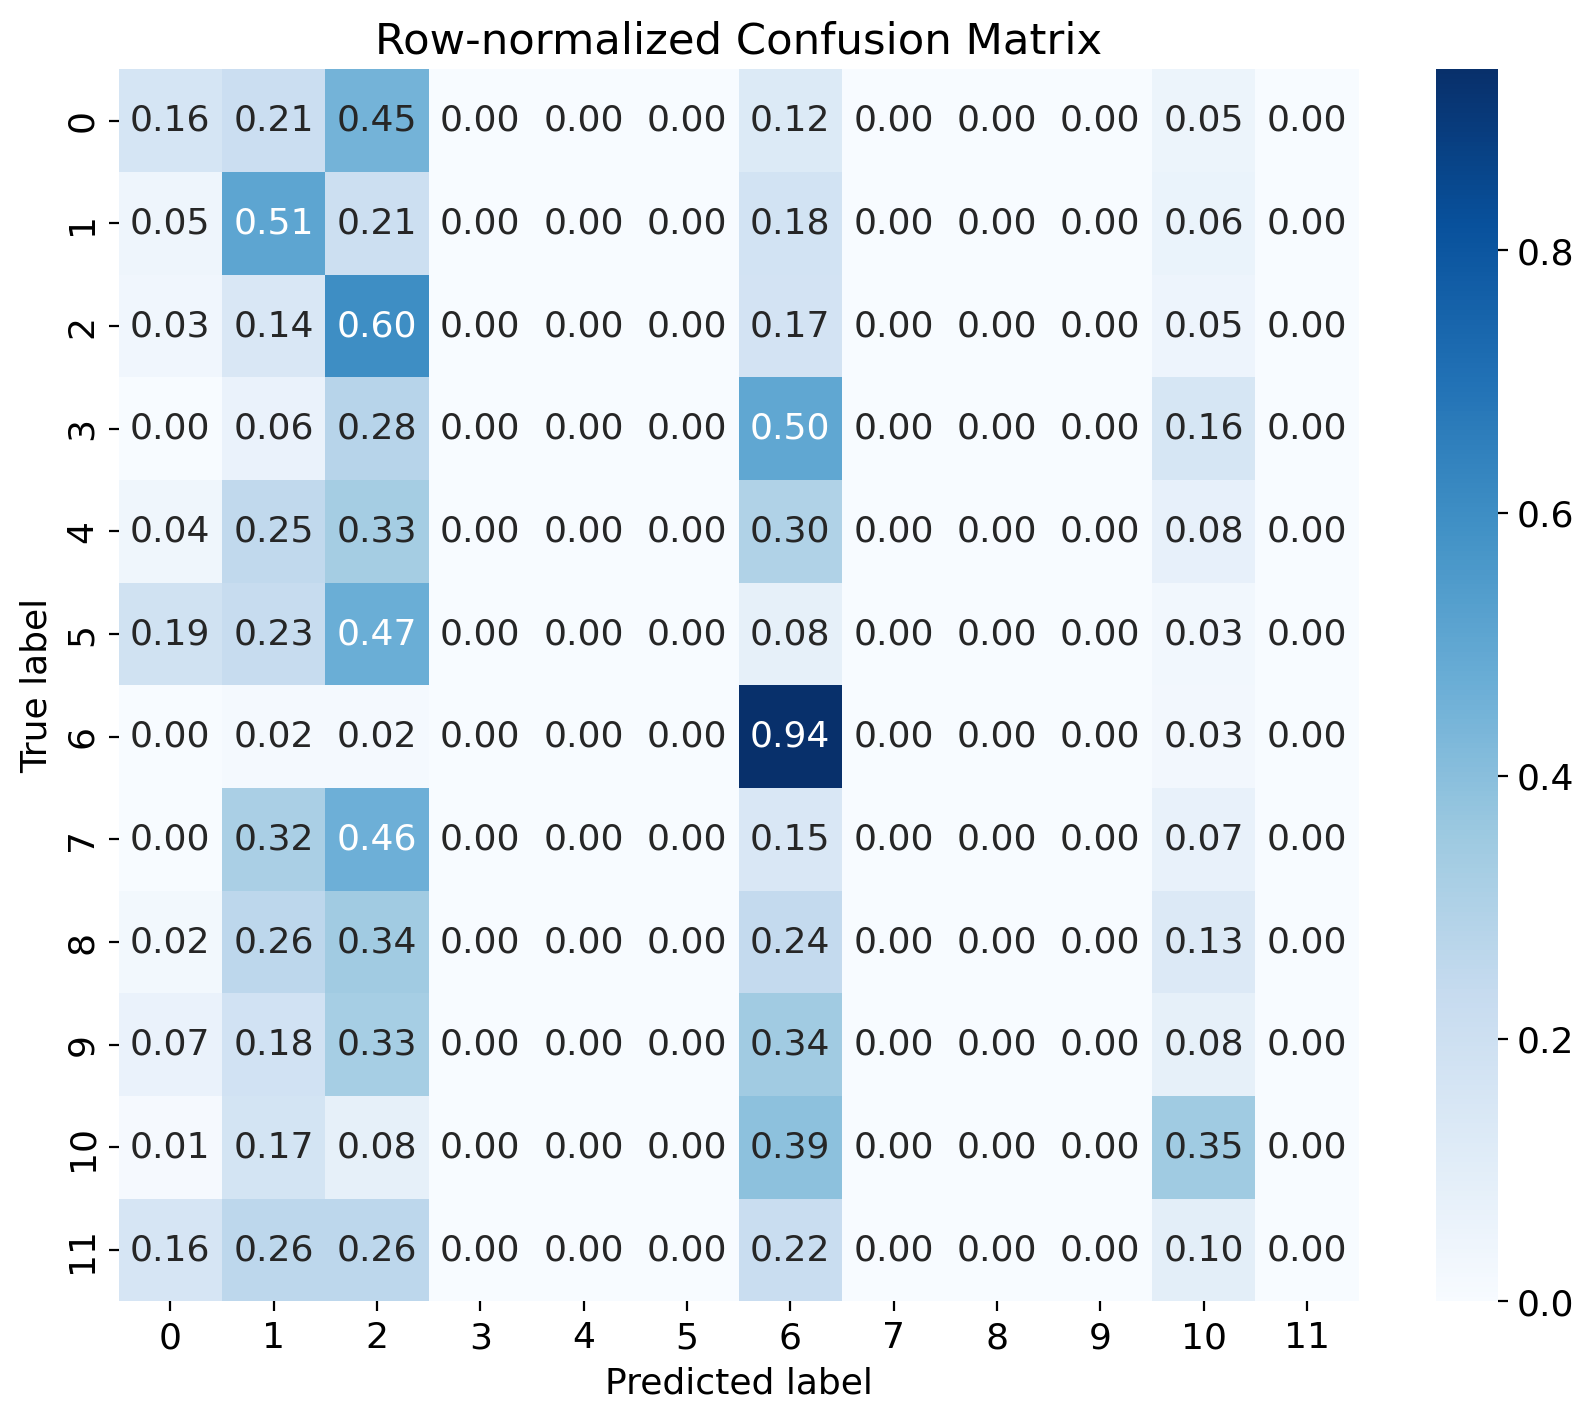

In [355]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# y_true and y_pred as before
y_true = np.argmax(y_test_df.values, axis=1)
y_pred = np.argmax(y_pred_df.values, axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=np.arange(12))

# Normalize so each row sums to 1 (handle zero rows to avoid division by zero)
row_sums = cm.sum(axis=1, keepdims=True)
row_sums[row_sums == 0] = 1  # avoid division by zero
cm_normalized = cm / row_sums

# Plot the normalized confusion matrix (values between 0 and 1)
plt.figure(figsize=(10, 8))
sns.heatmap(
    cm_normalized,
    annot=True,
    fmt='.2f',
    cmap='Blues',
    xticklabels=np.arange(12),
    yticklabels=np.arange(12)
)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Row-normalized Confusion Matrix')
plt.show()


### Make Accuracy Table

In [356]:
# Calculate accuracy for each category (class-wise accuracy)
class_accuracies = cm.diagonal() / cm.sum(axis=1) *100

# Calculate overall accuracy
overall_accuracy = cm.diagonal().sum() / cm.sum()*100

# Create a DataFrame for better visualization
accuracy_table = pd.DataFrame({
    'Class': np.arange(12),
    'Class Accuracy': class_accuracies
})

# Append overall accuracy as a separate row
overall_row = pd.DataFrame({'Class': ['Overall'], 'Class Accuracy': [overall_accuracy]})
accuracy_table = pd.concat([accuracy_table, overall_row], ignore_index=True)

print(accuracy_table)

      Class  Class Accuracy
0         0       16.192171
1         1       50.678175
2         2       60.000000
3         3        0.000000
4         4        0.000000
5         5        0.000000
6         6       93.762994
7         7        0.000000
8         8        0.000000
9         9        0.000000
10       10       34.540750
11       11        0.000000
12  Overall       61.123900
